# NPZD parameter estimation using a stochastic EnKF

 * This is an example of 4-dimensional, variational parameter estimation using a stochastic Ensemble Kalman Filter (SEnKF).
 * The ocean biological model used in this example is a simple 0-dimensional (single box) NPZD model with 6 parameters, of which any subset can be estimated.
 * To change the parameter estimation setup, the observations, or the SEnKF configuration, modify the settings in the **settings changeable by the user** cell below.
 * Despite its simplicity, this model can show the problems of parameter interdependence and underdetermination, the benefit of additional observations when estimating parameters, and the influence of additional error sources, such as uncertainty in the initial conditions.
 * A few predefined scenarios can be selected using the `scenarios` variable in the **settings changeable by the user** cell below.

The following scenarios are available:
#### Scenario 1: Underdetermined and interdependent parameters
Results show a strong dependence between the phytoplankton maximum grow rate (`vmax`) and the zooplankton growth rate (`graz`).
In this experiment, the nutrient half saturation parameter (`nuthalfsat`) is underdetermined and cannot be estimated accurately (the analysis solution has moved away from the true parameter value).

#### Scenario 2: One underdetermined mortality rate, part I
Using a series of nutrient observations, only the phytoplankton mortality (`mortP`) rate can be estimated accurately, while more uncertainty remains in the value of the zooplankton mortality rate (`mortZ`).
Compare this result to **scenario 3** which adds zooplankton observations and note the shape of the cost function.

#### Scenario 3: One underdetermined mortality rate, part II
Using zooplankton in addition to nutrient observations, both the phytoplankton mortality (`mortP`) and zooplankton mortality rate (`mortZ`) can be estimated accurately.

#### Scenario 4: The influence of additional error sources
This scenario is identical to **scenario 3** but adds an error to the estimate of the initial conditions which influences the parameter estimation. The analysis parameter estimate looks similarly precise as in **scenario 3**, but has a bias and is thus less accurate.

### preparation
Import packages, set default plotting parameters, and specify some colors.

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from math import atan2
from IPython.display import Markdown as md

mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['font.size'] = 20

# colorblind-friendly colors for N, P, Z, D
colors = {
    'N': '#4477AA',
    'P': '#228833',
    'Z': '#EE6677',
    'D': '#CCBB44',
}

# for use in labels
parameters_description = {
    'vmax': 'phytoplankton maximum growth rate',
    'nuthalfsat': 'nutrient half saturation',
    'graz': 'zooplankton grazing rate',
    'mortP': 'phytoplankton mortality rate',
    'mortZ': 'zooplankton mortality rate',
    'reminrate': 'nutrient remineralization rate',
}

variables_description = {
    'N': 'nutrients',
    'P': 'phytoplankton',
    'Z': 'zooplankton',
    'D': 'detritus',
}

# for creating a nicer looking legend
class HandlerEllipse(mpl.legend_handler.HandlerPatch):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent, height=height + ydescent)
        p2 = mpatches.Circle(xy=center, radius=0.4 * height, color='0.1')
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        p2.set_transform(trans)
        return [p, p2]

## settings changeable by the user

Below are the main settings that determine the parameter estimation configuration.

`np.random.seed(seed)`: Set an integer seed value for the pseudo-random number generator. Comment out this line to not set a seed and obtain different results every time the notebook is run.

`scenario`: Set to a number between 1 and 4 to run a predefined scenario, any other value will use the custom configuration determined by the following settings.

`parameters_true`: Contains the "true" values of the parameters that are used to determine the "truth", that is, the true state of the modeled system. `parameters_true` needs to contain all model parameters, even those that are not estimated/optimized.

`parameters_prior`: Contains the prior estimate of the parameters that are estimated/optimized, and thus the starting point of the parameter estimation/optimization. Parameters not listed in `parameters_prior` are not estimated and assumed to be constant, their values are kept at the values specified in `parameters_true`.

`parameters_uncertainty`: Contains the uncertainty for each parameter in `parameters_prior`. The initial sample or "population" of parameter values in the optimization algorithm is drawn from a normal distribution using the value in `parameters_prior` as mean and value in `parameters_uncertainty` as the standard deviation for each parameter that is being estimated.

`t`: Time vector determining the length and time-stepping for each model simulation. It is recommended to start t at 0 and use a time stepping of 1 day.

`obs_info`: Contains a one or multiple entries that determine the observations used in the parameter estimation. Each entry corresponds to an observation and needs to contain 3 values:
 1. A time index for t (integer), setting the time when the observation was taken.
 2. The observed variable ('N', 'P', 'Z', or 'D').
 3. The uncertainty of the observation.

The observations are then generated from the "truth" by indexing it at the specified time index for the specified variable and adding normal pseudo-random noise with a zero mean and standard deviation based on the specified uncertainty. To not add noise to the observations, see `perfect_observations` below.

`perfect_observations`: If set to `False` (default), the observation uncertainty in `obs_info` is used to add noise to the observations. If set to `True`, no noise is added, and the "true" state is observed perfectly. Note that the observation uncertainty is always used in the computation of the cost and fitness function.

`perfect_initial_conditions`: If set to `True` (default), the "truth" and all other model simulations use the same initial condition, that is, there is perfect knowledge of the initial conditions. If set to `False`, a new, imperfect initial condition is created from the "true" initial conditions and used for all model simulations except for the "truth". Note that only parameter values are estimated in this notebook, so an imperfect state adds uncertainty to the parameter estimation procedure.

`x0_true`: Specifies the "true" initial conditions.

`x0_uncertainty`: Specifies the uncertainty in the initial conditions, if `perfect_initial_conditions` is set to `False`. It acts as the standard deviation of pseudo-random normal, zero-mean noise that is added to `x0_true` to create the imperfect initial conditions, if `perfect_initial_conditions` is set to `False`.

`nens`: The number of ensemble members used in the SEnKF.

`show_cost`: If set to `True`, compute and display gridded cost function values in one of the plots. This can take a long time, and can be turned off by setting `show_cost` to `False`.

In [2]:
# set seed of pseudo-random number generator for reproducible results
np.random.seed(20220217)

# select a scenario (may override other options set)
# set scenario to 0 or None to not use a predefined scenario
scenario = 0

# true parameter values
parameters_true = {
    'vmax': 0.075,       # maximum growth rate in Michaelis Menten formulation
    'nuthalfsat': 0.3,   # nutrient half saturation in Michaelis Menten formulation
    'graz': 0.02,        # zooplankton grazing rate
    'mortP': 0.02,       # phytoplankton mortality rate
    'mortZ': 0.03,       # zooplankton mortality rate
    'reminrate': 0.1,    # remineralization rate
}

# select which parameters to estimate and what their prior values should be
parameters_prior = {
    'vmax': 0.1,
    'nuthalfsat': 0.4,
    'graz': 0.01,
}

# uncertaiinty in the prior parameter values
parameters_uncertainty = {
    'vmax': 0.1,
    'nuthalfsat': 0.1,
    'graz': 0.01,
}

# initialize time vector (default: 2 years)
t = np.arange(0.0, 2 * 365.0, 1.0)

# select when to observe state in time, which variable, and with which uncertainty
obs_info = [
# each entry contains
# (time (index for t, integer), variable ('N', 'P', 'Z', or 'D'),  observation uncertainty)
    ( 50, 'P', 0.01),
    (100, 'P', 0.01),
    (150, 'P', 0.01),
    (200, 'P', 0.01),
    (250, 'P', 0.01),
    (300, 'P', 0.01),
    (350, 'P', 0.01),
    (400, 'P', 0.01),
    (450, 'P', 0.01),
    (500, 'P', 0.01),
]

perfect_observations = False

perfect_initial_conditions = True

# initial conditions
x0_true = np.array((0.6, 0.15, 0.2, 0.05))

# uncertainty in initial conditions
x0_uncertainty = np.array((0.03, 0.03, 0.03, 0.03))

# number of ensemble members
nens = 40

# show cost function grid
show_cost = True

### scenario-related options

In [3]:
if scenario == 1:
    t = np.arange(0.0, 2 * 365.0, 1.0)
    parameters_prior = {
        'vmax': 0.1,
        'nuthalfsat': 0.4,
        'graz': 0.01,
    }
    parameters_uncertainty = {
        'vmax': 0.1,
        'nuthalfsat': 0.1,
        'graz': 0.01,
    }
    perfect_observations = False
    perfect_initial_conditions = True
    obs_info = [(it, 'P', 0.01) for it in range(50, 500 + 1, 50)]
    message = '''# Scenario 1: Underdetermined and interdependent parameters
Results show a strong dependence between the phytoplankton maximum grow rate (`vmax`) and the zooplankton growth rate (`graz`).
In this experiment, the nutrient half saturation parameter (`nuthalfsat`) is underdetermined and cannot be estimated accurately (the analysis solution has moved away from the true parameter value).
    '''
elif scenario in (2, 3, 4):
    t = np.arange(0.0, 2 * 365.0, 1.0)
    parameters_prior = {
        'mortP': 0.01,
        'mortZ': 0.02,
    }
    parameters_uncertainty = {
        'mortP': 0.01,
        'mortZ': 0.01,
    }
    perfect_observations = False
    perfect_initial_conditions = True
    obs_info = [(it, 'N', 0.003) for it in range(50, 500 + 1, 50)]

    if scenario >= 3:
        obs_info.extend([(it, 'Z', 0.003) for it in range(50, 500 + 1, 50)])
    if scenario >= 4:
        perfect_initial_conditions = False

    if scenario == 2:
        message = '''# Scenario 2: One underdetermined mortality rate, part I
Using a series of nutrient observations, only the phytoplankton mortality (`mortP`) rate can be estimated accurately, while there remains more uncertainty in the value of the zooplankton mortality rate (`mortZ`).
Compare this result to **scenario 3** which adds zooplankton observations and note the shape of the cost function.'''
    elif scenario == 3:
        obs_info.extend([(it, 'Z', 0.003) for it in range(50, 500 + 1, 50)])
        message = '''# Scenario 3: One underdetermined mortality rate, part II
Using zooplankton in addition to nutrient observations, both the phytoplankton mortality (`mortP`) and zooplankton mortality rate (`mortZ`) can be estimated accurately.
Compare this result to **scenario 2** which contains no zooplankton observations, but is otherwise identical.'''
    elif scenario == 4:
        obs_info.extend([(it, 'Z', 0.003) for it in range(50, 500 + 1, 50)])
        message = '''# Scenario 4: The influence of additional error sources
This scenario is identical to **scenario 3** but adds an error to the estimate of the initial conditions which influences the parameter estimation. The analysis parameter estimate looks similarly precise as in **scenario 3**, but has a bias and is thus less accurate.'''
else:
    message = '''# No active scenario
    Using custom configuration without modifications.'''

md(message)

# No active scenario
    Using custom configuration without modifications.

### evaluate and check user input

In [4]:
if perfect_initial_conditions:
    x0_estimate = x0_true.copy()
else:
    x0_estimate = np.maximum(1e-6, x0_true + x0_uncertainty * np.random.normal(size=x0_true.size))
    print(x0_estimate)

assert len(parameters_prior) >= 2, 'At least two parameters must be contained in "parameters_prior".'

for param in parameters_description:
    if param not in parameters_true:
        raise KeyError('Parameter "{}" missing from "parameters_true".'.format(param))

for param in parameters_prior:
    if param not in parameters_uncertainty:
        raise KeyError('Parameter "{}" missing from "parameters_uncertainty".'.format(param))

for i, oi in enumerate(obs_info):
    assert oi[0] < len(t), 'Observation {}: index {} out of bounds for time vector "t".'.format(i + 1, oi[0])
    assert oi[1] in 'NPZD', 'Observation {}: variable "{}" must be one of "N", "P", "Z", or "D".'.format(i + 1, oi[1])
    assert oi[2] > 0, 'Observation {}: Observation error must be greater than zero.'.format(i + 1, oi[2])

### model code

In [5]:
# model
def npzd(x, t, parameters, light):
    '''
    input
    =====
    x: model state
    t: current time (in days)
    parameters: model parameters
    light: light function returning irradiance at time t
    '''
    n, p, z, d = np.maximum(x, 0.0)

    growth = parameters['vmax'] * n / (parameters['nuthalfsat'] + n) * light(t) * p
    grazing = parameters['graz'] * p * z
    p_loss = parameters['mortP'] * p
    z_loss = parameters['mortZ'] * z * z
    remin = parameters['reminrate'] * d

    return np.array((-growth+remin, growth-grazing-p_loss, grazing-z_loss, p_loss+z_loss-remin))

# light function returning irradiance at time t
def light(t):
    return 1.0 + 0.5*(0.8 * np.sin(np.pi*((t-81.25)/182.5)) - 0.8)

### helper functions to run model

In [6]:
parameter_minval = 1e-6

def run_model(parameter_values=None, x0=None):
    if x0 is None:
        x0 = x0_estimate
    parameters_run = parameters_true.copy()
    if parameter_values is not None:
        if isinstance(parameter_values, dict):
            parameters_run.update(parameter_values)
        else:
            assert len(parameter_values) == len(parameters_prior), ('The number of input parameters must'
                                                                    f' be {len(parameters_prior)}.')
            for p, v in zip(parameters_prior, parameter_values):
                parameters_run[p] = v
    return odeint(npzd, x0, t, args=(parameters_run, light))

def observation_operator(trajectory, obs_info=obs_info):
    return np.array([trajectory[oi[0], 'NPZD'.index(oi[1])] for oi in obs_info])

### generate synthetic data from "true" parameters (`parameters_true`)

In [7]:
npar = len(parameters_prior)
nobs = len(obs_info)

# use model to generate the true state and add observation error to create synthetic observations
state_true = observation_operator(run_model(x0=x0_true))

# extract observation uncertainty
obs_uncertainty = np.array([oi[2] for oi in obs_info])

# generate observations
if perfect_observations:
    obs = state_true
else:
    obs = state_true + obs_uncertainty * np.random.normal(size=state_true.size)

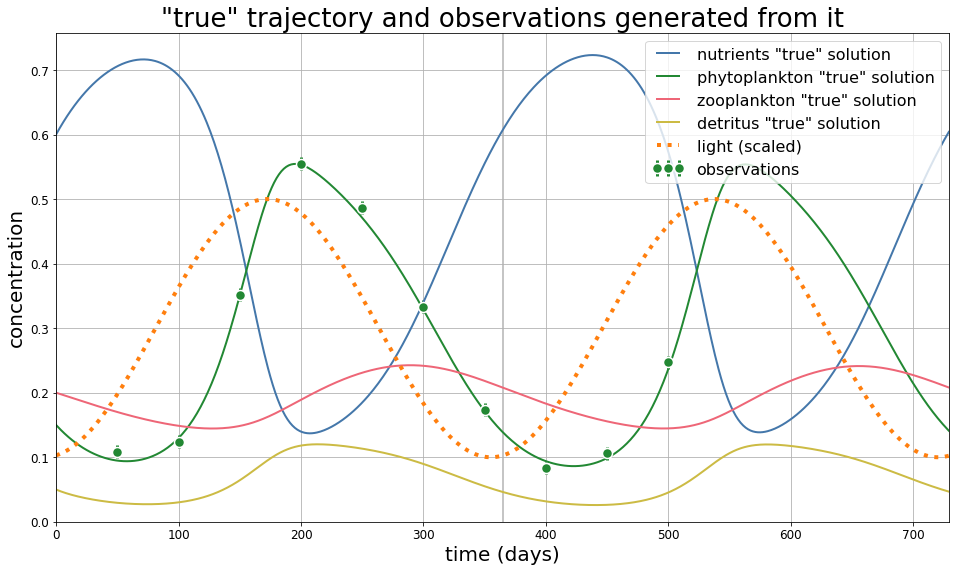

In [8]:
fig, ax = plt.subplots()

trajectory = run_model(x0=x0_true)
for i, name in enumerate(('N', 'P', 'Z', 'D')):
    ax.plot(t, trajectory[:,i], color=colors[name], lw=2,
            label=f'{variables_description[name]} "true" solution')

for oi, y in zip(obs_info, obs):
    eb = ax.errorbar(x=t[oi[0]], y=y, yerr=oi[2], color=colors[oi[1]], marker='o',
                     markeredgecolor='white', markeredgewidth=1.5, lw=3, markersize=10)

ax.axvline(365, color='0.7', zorder=0)
ax.plot(t, 0.5 * light(t), linestyle=':', color='#ff7f0e', label='light (scaled)', lw=4)

ax.set(title='"true" trajectory and observations generated from it',
       xlabel='time (days)', ylabel='concentration', xlim=(t[0], t[-1]))
if ax.get_ylim()[0] < 0:
    ax.set_ylim(bottom=0.0)
ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
handles.append(eb)
labels.append('observations')
ax.legend(handles, labels, loc='upper right', numpoints=3)
None

### create and plot ensemble

In [9]:
# generate ensemble of observations adding pseudo-random noise to obs_true
Y = obs[:,None] + obs_uncertainty[:,None] * np.random.normal(size=(nobs, nens))

# generate the forecast ensemble of parameters X by adding pseudo-random noise to the parameters
parameters_prior_array = np.array([parameters_prior[p] for p in parameters_prior])
parameters_uncertainty_array = np.array([parameters_uncertainty[p] for p in parameters_prior])
X = np.maximum(parameter_minval, parameters_prior_array[:, None] + parameters_uncertainty_array[:, None] *
               np.random.normal(size=(npar, nens)))

# for each initial condition in X, run the NPZD model to generate HX, the forecast ensemble of model states
# at the observation locations
HX = np.empty((nobs, nens))
for iens, params in enumerate(X.T):
    HX[:, iens] = observation_operator(run_model(parameter_values=params))

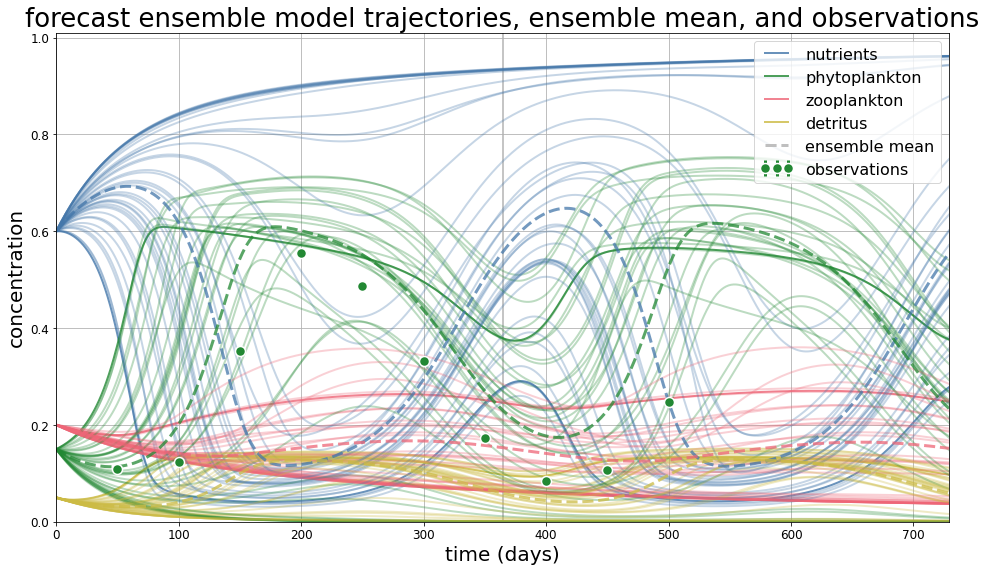

In [10]:
# upper limit on number of trajectories to include in plot
max_plot = 50

def plot_trajectories(ax, ensemble, plot_mean=True, show_observation_ensemble=False):
    for iens, params in enumerate(ensemble[:, :max_plot].T):
        trajectory = run_model(parameter_values=params)
        label = None
        for i, name in enumerate(('N', 'P', 'Z', 'D')):
            if iens == 0:
                label = variables_description[name]
            ax.plot(t, trajectory[:,i], color=colors[name], label=label, lw=2, alpha=0.3)

    trajectory = run_model(parameter_values=np.mean(ensemble, axis=1))
    for i, name in enumerate(('N', 'P', 'Z', 'D')):
        ax.plot(t, trajectory[:,i], color=colors[name], label=label, lw=3, alpha=0.75, ls='--')

    for oi, y, y_ens in zip(obs_info, obs, Y):
        eb = ax.errorbar(x=t[oi[0]], y=y, yerr=oi[2], color=colors[oi[1]], marker='o', ls='none',
                         markeredgecolor='white', markeredgewidth=1.5, lw=3, markersize=10)
        if show_observation_ensemble:
            oe = ax.scatter(x=np.full(y_ens.size, fill_value=t[oi[0]]), y=y_ens, color=colors[oi[1]],
                            marker='.', alpha=0.5)

    for x in range(365, int(t[-1]), 365):
        ax.axvline(x, color='0.7', zorder=0)

    ax.set(xlabel='time (days)', ylabel='concentration', xlim=(t[0], t[-1]))
    if ax.get_ylim()[0] < 0:
        ax.set_ylim(bottom=0.0)
    ax.grid(True)

    handles, labels = ax.get_legend_handles_labels()
    for h in handles:
        h.set_alpha(0.8)
    handles.append(mpl.lines.Line2D([], [], color='0.75', lw=3, ls='--'))
    labels.append('ensemble mean')
    handles.append(eb)
    labels.append('observations')
    if show_observation_ensemble:
        handles.append(oe)
        labels.append('observation ensemble')
    ax.legend(handles, labels, loc='upper right', numpoints=3)

fig, ax = plt.subplots()

plot_trajectories(ax, X)

ax.set(title='forecast ensemble model trajectories, ensemble mean, and observations')

None

### code to perform data assimilation

Run the Ensemble Kalman Filter. Below, the symbols denote:

`HBHT`: $\mathbf{H}\mathbf{B}\mathbf{H}^T$

`BHT`: $\mathbf{B}\mathbf{H}^T$

`R`: $\mathbf{R}$

`K`: $\mathbf{B}\mathbf{H}^T \left(\mathbf{H}\mathbf{B}\mathbf{H}^T + \mathbf{R}\right)$ (Kalman gain)

In [11]:
HBHT = np.cov(HX)
BHT = np.cov(X, HX)[:npar, -nobs:]
R = np.diag(obs_uncertainty)

K = BHT @ np.linalg.inv(HBHT + R)

# use kalman gain to compute update for each ensemble member in X, and store updated ensemble in X_post
X_post = np.empty_like(X)
for iens in range(nens):
    X_post[:, iens] = X[:, iens] + K @ (Y[:,iens] - HX[:,iens])

# one-line version
#X_post = X + np.array([K @ (y - Hx) for y, Hx in zip(Y.T, HX.T)]).T

### plot analysis ensemble

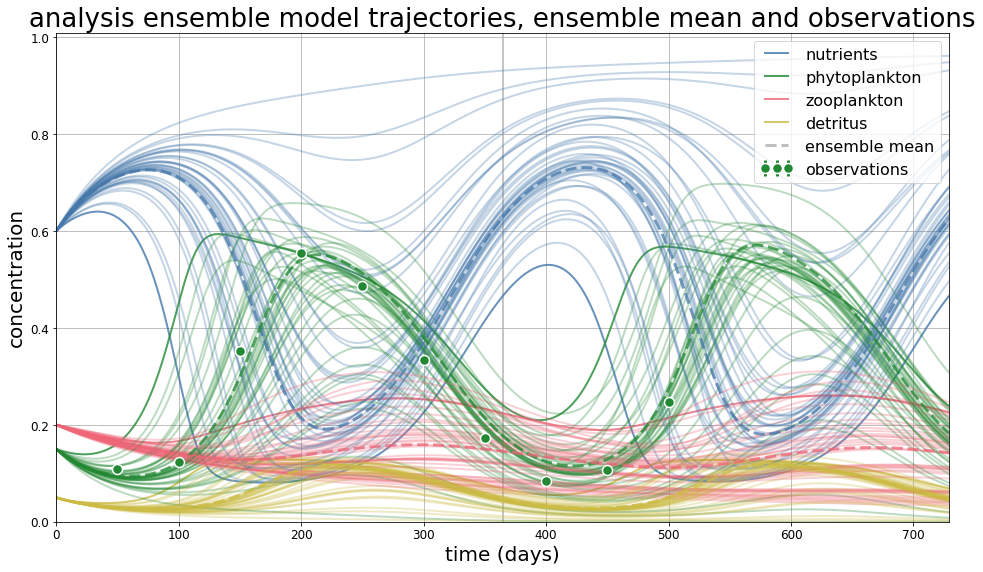

In [12]:
# upper limit on number of trajectories to include in plot
max_plot = 50

fig, ax = plt.subplots()

plot_trajectories(ax, X_post)

ax.set(title='analysis ensemble model trajectories, ensemble mean and observations')

None

### compute gridded cost function (if desired)

**Note:** If this step takes too much time, set `show_cost` to `False`.

In [13]:
parameters_list = list(parameters_prior)

include_forecast = True

B_inv = np.diag(1 / np.array([parameters_uncertainty[p] for p in parameters_prior])**2)

def compute_cost(parameter_values, x0=None, include_j_b=True):
    j_o = np.sum(((obs - observation_operator(run_model(parameter_values=parameter_values, x0=x0)))
                  / obs_uncertainty)**2)
    if not include_j_b:
        return j_o
    parameters_array = np.array([parameter_values[p] if p in parameter_values else parameters_prior[p] for p in parameters_prior])
    tmp = parameters_prior_array - parameters_array
    j_b = tmp[None, :] @ B_inv @ tmp[:, None]
    return 0.5 * (j_o + j_b)


if show_cost:
    res = 20
    cost_slices = {}
    cost_grid = {}
    for p0 in parameters_prior:
        for p1 in parameters_prior:
            if p0 >= p1:
                continue
            key = tuple((p0, p1))
            if key in cost_slices:
                continue

            for p in (p0, p1):
                if p in cost_grid:
                    continue
                i = parameters_list.index(p)
                p_range = np.array([min(np.min(X_post[i, :]), parameters_true[p]),
                                    max(np.max(X_post[i, :]), parameters_true[p])])
                if include_forecast:
                    p_range[0] = min(p_range[0], np.min(X[i, :]))
                    p_range[1] = max(p_range[1], np.max(X[i, :]))
                cost_grid[p] = np.linspace(p_range[0], p_range[1], res)

            cost_slices[key] = np.empty((res, res))
            for i0, v0 in enumerate(cost_grid[p0]):
                for i1, v1 in enumerate(cost_grid[p1]):
                    cost_slices[key][i0, i1] = compute_cost(parameter_values={p0: v0, p1: v1}, x0=x0_estimate)

### prepare plotting

In [14]:
def draw_ellipse(ax, cov=None, xy=None, ensemble=None, **plotargs):
    if ensemble is not None:
        xy = np.mean(ensemble, axis=1)
        cov = np.cov(ensemble)

    assert cov.shape == (2, 2), 'Covariance matrix must be 2 x 2.'

    a = cov[0, 0]
    b = cov[1, 0]
    c = cov[1, 1]

    tmp = np.sqrt((0.5 * (a - c))**2 + b**2)
    l1 = 0.5 * (a + c) + tmp
    l2 = 0.5 * (a + c) - tmp

    if b == 0 and a >= c:
        angle = 0
    elif b == 0 and a < c:
        angle = 90
    else:
        angle = atan2(l1 - a, b) * 180 / np.pi

    e = mpatches.Ellipse(xy, width=2*np.sqrt(l1), height=2*np.sqrt(l2), angle=angle, **plotargs)

    ax.add_artist(e)


def draw_ensemble(ax, ensemble, color=None, label=None, marker='o'):
    ax.plot(ensemble[0, :], ensemble[1, :], ls='none', marker=marker, ms=5, color=color, alpha=0.8, mec='none',
            label=label)
    draw_ellipse(ax, ensemble=ensemble, color=color, alpha=0.2, zorder=0.2)
    ax.plot(np.mean(ensemble[0, :]), np.mean(ensemble[1, :]), ls='none', marker=marker, ms=15, mew=3, color=color)

### plotting

Plot the ensemble and associated normal distribution (mean and covariance ellipse) before and after assimilation.

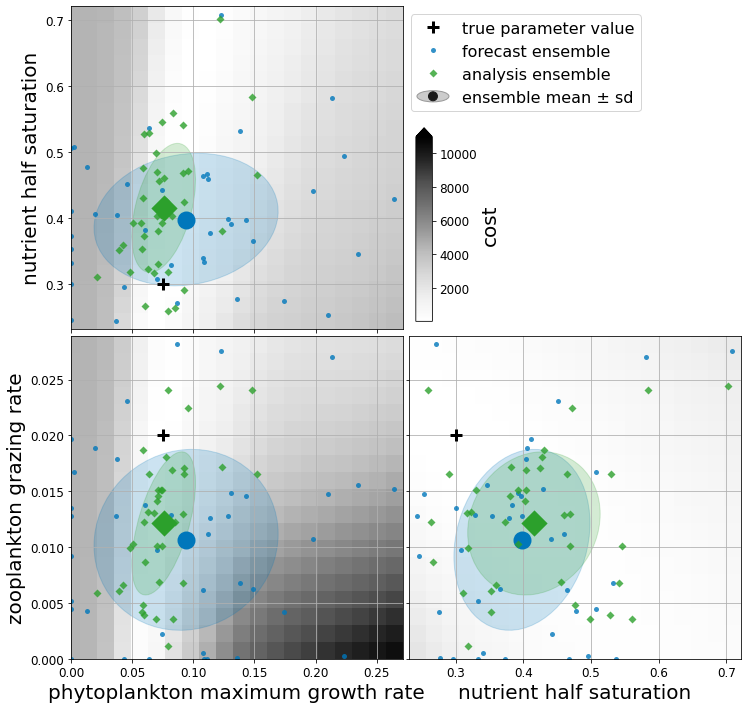

In [15]:
nrows = npar - 1
ncols = npar - 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows), sharex='col', sharey='row',
                        squeeze=False, gridspec_kw={'hspace': 0.02, 'wspace': 0.02})

parameter_names = {i: k for i, k in enumerate(parameters_prior)}
pcs = []
for icol, ix in enumerate(range(npar - 1)):
    for irow, iy in enumerate(range(1, npar)):
        ax = axs[irow, icol]
        if irow < icol:
            ax.set_visible(False)
            continue

        x_name = parameter_names[ix]
        y_name = parameter_names[iy]

        if irow == npar - 2:
            ax.set_xlabel(parameters_description[x_name])
        if icol == 0:
            ax.set_ylabel(parameters_description[y_name])

        ax.plot(parameters_true[parameter_names[ix]], parameters_true[parameter_names[iy]], marker='+',
                linestyle='none', markersize=12, markeredgewidth=3, markeredgecolor='black',
                label='true parameter value')
        draw_ensemble(ax, X[(ix, iy), :], color='#0077bb', label='forecast ensemble')
        draw_ensemble(ax, X_post[(ix, iy), :], color='#2ca02c', marker='D', label='analysis ensemble')

        if show_cost:
            if (x_name, y_name) in cost_slices:
                pcs.append(ax.pcolormesh(cost_grid[x_name], cost_grid[y_name], cost_slices[(x_name, y_name)].T,
                                         shading='nearest', cmap=mpl.cm.Greys, zorder=0))
            else:
                pcs.append(ax.pcolormesh(cost_grid[x_name], cost_grid[y_name], cost_slices[(y_name, x_name)],
                                         shading='nearest', cmap=mpl.cm.Greys, zorder=0))
        if ax.get_xlim()[0] < 0:
            ax.set_xlim(left=0.0)
        if ax.get_ylim()[0] < 0:
            ax.set_ylim(bottom=0.0)
        ax.grid(True)

        if irow == 0 and icol == 0:
            handles, labels = ax.get_legend_handles_labels()
            handles.append(mpatches.Ellipse((0.5, 0.5), width=2, height=1, angle=0, edgecolor='0.6', facecolor='0.8'))
            labels.append('ensemble mean ± sd')
            ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0, 1, 1),
                      handler_map={mpatches.Ellipse: HandlerEllipse()})

if show_cost:
    # equalize color scale for background cost function across panels
    vmin = 100000.
    vmax = 0.
    for pc in pcs:
        vmin = min(vmin, pc.norm.vmin)
        vmax = max(vmax, pc.norm.vmax)
    for pc in pcs:
        pc.norm.vmin = vmin
        pc.norm.vmax = vmax

    ax = axs[0, 0]
    cax = ax.inset_axes([1.04, 0.025, 0.05, 0.6], transform=ax.transAxes)
    fig.colorbar(pcs[0], ax=ax, cax=cax, label='cost', extend='max')
None